# **Protocol title: FUSCA Tutorial - 3k PBMC dataset**

Compiled: 2022-04-26

# **Authors**
Edroaldo Lummertz da Rocha<sup>1</sup>, Gabriela Flávia Rodrigues Luiz<sup>1</sup>, Marcelo Falchetti<sup>2</sup>

Author Affiliations
- 1 Department of Microbiology, Immunology and Parasitology, Federal University of Santa Catarina, Florianópolis, SC, 88040-900, Brazil
- 2 Graduate Program of Pharmacology, Center for Biological Sciences, Federal University of Santa Catarina, Florianópolis, SC, 88040-900, Brazil

Corresponding Author: Edroaldo Lummertz da Rocha,

edroaldo.lummertz@ufsc.br / edroaldo@gmail.com

## 1. Install dependencies

In [ ]:
list.of.packages <- c('cccd', 'grid', 'tsne', 'Rtsne', 'igraph', 'mclust', 'ggplot2', 'pheatmap', 'reshape', 'reshape2')
new.packages <- list.of.packages[!(list.of.packages %in% installed.packages()[, "Package"])]
if(length(new.packages)) install.packages(new.packages, repos = c("http://cran.rstudio.com/", "https://bioconductor.org/biocLite.R"))

# In case of a missing package after running the steps above, please install them by typing:
source('http://bioconductor.org/biocLite.R')
biocLite('package_name')

# The package Vennerable also needs to be installed:
install.packages("Vennerable", repos = "http://R-Forge.R-project.org")

# Install FUSCA
library(devtools)
devtools::install_github("edroaldo/fusca")

## 2. Load libraries

In [2]:
list.of.packages<-c("cccd", "grid", "Rcpp", "tsne", "uwot", "dplyr", "fusca", "Rtsne", "igraph", "Matrix", "mclust", "tibble", 
                    "cowplot", "ggplot2", "reshape", "reshape2", "pheatmap")
lapply(list.of.packages, require, character.only = TRUE); rm(list.of.packages)

[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

[[5]]
[1] TRUE

[[6]]
[1] TRUE

[[7]]
[1] TRUE

[[8]]
[1] TRUE

[[9]]
[1] TRUE

[[10]]
[1] TRUE

[[11]]
[1] TRUE

[[12]]
[1] TRUE

[[13]]
[1] TRUE

[[14]]
[1] TRUE

[[15]]
[1] TRUE

[[16]]
[1] TRUE

[[17]]
[1] TRUE

## 3. Set the working directory and seed

In [3]:
set.seed(42)
setwd("/workspace/Edroaldo/CellComm")

## 4. Load the PBMC dataset (download data from https://cf.10xgenomics.com/samples/cell/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz)

In [4]:
#data = read10X("filtered_gene_bc_matrices/hg19")
data = readMM("filtered_gene_bc_matrices/hg19/matrix.mtx");
genes <- make.unique(read.delim("filtered_gene_bc_matrices/hg19/genes.tsv", header = FALSE, stringsAsFactors = FALSE)$V2, sep = ".");
rownames(data) = genes;
colnames(data) <- read.delim("filtered_gene_bc_matrices/hg19/barcodes.tsv", header = FALSE, stringsAsFactors = FALSE)$V1
data = as(data, "dgCMatrix")
data[1:5, 1:5]

5 x 5 sparse Matrix of class "dgCMatrix"
             AAACATACAACCAC-1 AAACATTGAGCTAC-1 AAACATTGATCAGC-1
MIR1302-10                  .                .                .
FAM138A                     .                .                .
OR4F5                       .                .                .
RP11-34P13.7                .                .                .
RP11-34P13.8                .                .                .
             AAACCGTGCTTCCG-1 AAACCGTGTATGCG-1
MIR1302-10                  .                .
FAM138A                     .                .
OR4F5                       .                .
RP11-34P13.7                .                .
RP11-34P13.8                .                .

## 5. Create cellRouter object with PBMC data

We create the CellRouter object using the *CreateCellRouter* function and PBMC data. 

Parameters of *CreateCellRouter* function:
- assay.type = "RNA", defining transcriptomics analysis.
- min.genes = “200”, defining the minimum number of genes that a cell must express to be considered.
- min.cells = “3”, defining the minimum number of cells that a gene is expressed (counts > 0) to be considered.
- is.expr = “0”, defining the minimum expression value (counts) a gene must have to be considered expressed.

In [5]:
cellrouter.pbmc <- CreateCellRouter(data, assay.type = "RNA", min.genes = 200, min.cells = 3, is.expr = 0)

[1] 13714  2700


## 6. Filter out cells based on a list of variables

Calculating the percentage of reads that map to mitochondrial and ribosomal genes.

PS: High percentage of mitochondrial genes are indicative of poor-quality cells. Few unique genes per cell are indicative of low-quallity cell while very high genes per cell may be doublets.

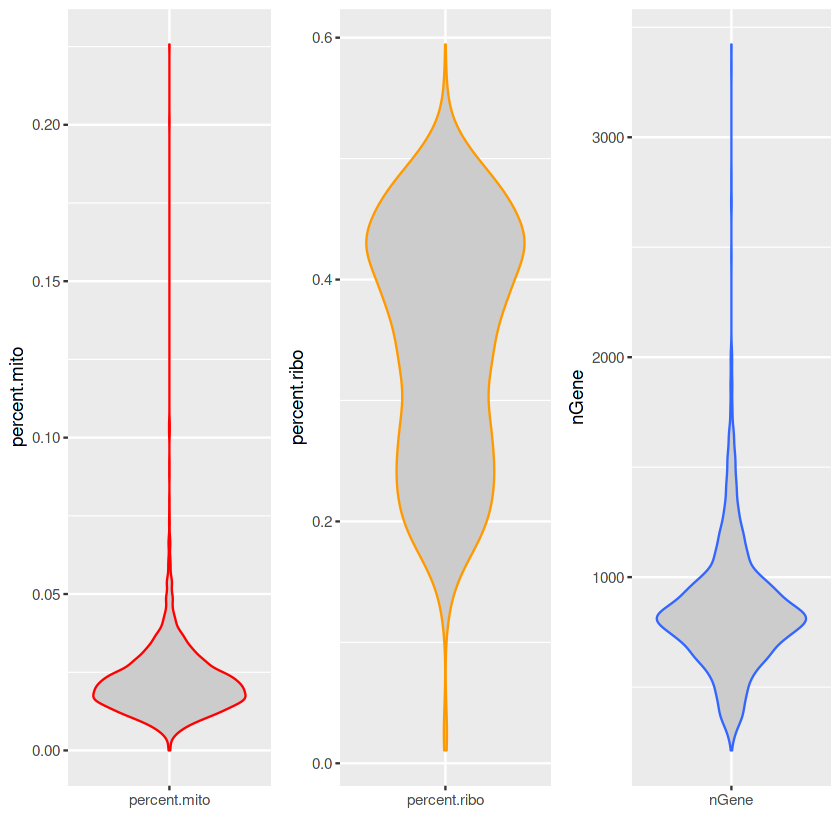

In [6]:
mito.genes <- grep(pattern = "^MT-", x = rownames(x = cellrouter.pbmc@assays$RNA@ndata), value = TRUE)
percent.mito <- Matrix::colSums(cellrouter.pbmc@assays$RNA@ndata[mito.genes, ]) / Matrix::colSums(cellrouter.pbmc@assays$RNA@ndata)
ribo.genes <- grep(pattern = "^RP[SL]", x = rownames(x = cellrouter.pbmc@assays$RNA@ndata), value = TRUE)
percent.ribo <- Matrix::colSums(cellrouter.pbmc@assays$RNA@ndata[ribo.genes, ]) / Matrix::colSums(cellrouter.pbmc@assays$RNA@ndata)

cellrouter.pbmc@assays$RNA@sampTab$percent.mito = percent.mito
cellrouter.pbmc@assays$RNA@sampTab$percent.ribo = percent.ribo

p1 = ggplot(cellrouter.pbmc@assays$RNA@sampTab, aes(x = "percent.mito", y = percent.mito)) + 
    geom_violin(fill = "grey80", colour = "#FF0000") + theme(legend.position = "none") + xlab("") 
p2 = ggplot(cellrouter.pbmc@assays$RNA@sampTab, aes(x = "percent.ribo", y = percent.ribo)) + 
    geom_violin(fill = "grey80", colour = "#FF9900") + theme(legend.position = "none") + xlab("") 
p3 = ggplot(cellrouter.pbmc@assays$RNA@sampTab, aes(x = "nGene", y = nGene)) + 
    geom_violin(fill = "grey80", colour = "#3366FF") + theme(legend.position = "none") + xlab("") 
plot_grid(p1, p2, p3, nrow = 1) # labels = "")

cellrouter.pbmc <- filterCells(cellrouter.pbmc, assay.type = "RNA", 
                               variables = c("nGene", "percent.mito"), 
                               thresholds.low = c(200, -Inf, 0.10), thresholds.high = c(2500, 0.05, Inf))

## 7. Normalizing the data

To normalize the expression data, we use the *Normalize* function.

In [7]:
cellrouter.pbmc <- Normalize(cellrouter.pbmc)

## 8. Identify high variable genes, rank them and use the top 2000 genes.

We use the function *FindVariableGenes* to identify the genes with the highest variance of expression. 

Parameters of *FindVariableGenes* function:
- assay.type = "RNA", defining transcriptomics analysis.
- method = "vst", defining the method for variable's identification.
- pvalue = "0.05", defining the p-value threshold for the considered genes.

In [8]:
var.genes <- FindVariableGenes(cellrouter.pbmc, assay.type = "RNA", method = "vst", loess.span = 0.3, pvalue = 0.05)
cellrouter.pbmc@var.genes <- rownames(var.genes[1:2000, ])

[1] "warnings supressed"
[1] "finished warnings?"


# 9. Scaling the data

To scale the data, we use the *scaleData* function and the 2000 most variable genes.

In [9]:
cellrouter.pbmc <- scaleData(cellrouter.pbmc, genes.use = cellrouter.pbmc@var.genes)

## 10. Dimensional reduction

We reduce the dimensionality of the data using linear method, Principal Component Analysis (PCA) using the *computePCA* function and non-linear method, Uniform Manifold Approximation and Projection (UMAP) using the *umap* function from Uwot package. 

Parameters of *computePCA* function:
- assay.type = "RNA", defining transcriptomics analysis.
- seed = 42, sets the seed of R‘s random number generator, which is useful for creating simulations or random objects/analysis that can be reproduced.
- num.pcs = 50, defining the number of principal components to compute.
- genes.use = “cellrouter.pbmc@var.genes”; defining the genes to compute the PCA. Here we used the 2000 most variable genes.

Parameters of uwot::*umap* function:
- X = “cellrouter.pbmc@pca$cell.embeddings[, 1:pc]”, input data with the number of principal components (pc) to compute.
- spread = 1, defining the effective scale of embedded points.
- min_dist = 0.3, defining how close the points appear in the final layout.
- n_neighbors = 30, defining the number of nearest neighbors.
- metric = "cosine", defining the distances between data points to compute.

In [ ]:
cellrouter.pbmc <- computePCA(cellrouter.pbmc, assay.type = "RNA", seed = 42, num.pcs = 50, genes.use = cellrouter.pbmc@var.genes) 
umap.done <- uwot::umap(cellrouter.pbmc@pca$cell.embeddings[, 1:15], spread = 1, min_dist = 0.3, n_neighbors = 30, metric = "cosine")
rownames(umap.done) <- rownames(cellrouter.pbmc@pca$cell.embeddings)
colnames(umap.done) <- c("UMAP1", "UMAP2")
cellrouter.pbmc <- customSpace(object = cellrouter.pbmc, matrix = umap.done)

## 11. Cluster identification

We identified clusters defined by transcriptional variance and identified after dimensionality reduction using the *findClusters* function. 

Parameters of *findClusters* function:
- k = 15, defining the number of nearest neighbors to build a k-nearest neighbors graph.
- num.pcs = 15, defining the number of principal components to compute.
- nn.type = "snn", defining the method to find the k-nearest neighbors graph.

In [ ]:
cellrouter.pbmc <- findClusters(cellrouter.pbmc, k = 15, num.pcs = 15, nn.type = "snn")
plotReducedDimension(cellrouter.pbmc, reduction.type = "custom", annotation = "population", annotation.color = "colors",
                     showlabels = T, dotsize = 0.01, labelsize = 5, convex = FALSE)

## 12. Identification of cluster-specific gene signatures and marker genes

Parameters of *findSignatures* function:
- assay.type = "RNA", defining transcriptomics analysis.
- column = “population”, defining the column with the groups in metadata.
- test.use = "wilcox", defining the differential expression test to use.
- min.pct = 0.25, defining the minimum percentage of detection.
- fc.threshold = 0.25, defining the fold change threshold.
- pos.only = TRUE, defining to get only the up-regulated genes.

In [ ]:
markers <- findSignatures(cellrouter.pbmc, assay.type = "RNA", column = "population", 
                          test.use = "wilcox", min.pct = 0.25, fc.threshold = 0.25, pos.only = T) 
markers.top5 <- as.data.frame(markers %>% 
                              group_by(population) %>% 
                              top_n(5, fc))
plot <- plotSignaturesHeatmap(cellrouter.pbmc, assay.type = "RNA", markers.top5, genes.show = as.vector(markers.top5$gene), threshold =  3, 
                              column.ann = "population", column.color = "colors")
grid::grid.draw(plot$gtable)

## 13. Assigning cell type to clusters

Plotting gene expression on a UMAP projection for selected genes.

In [ ]:
# Plot gene expression
genelist = c("MS4A1", "GNLY", "CD3E", "CD14", "FCER1A", "FCGR3A", "LYZ", "PPBP", "CD8A")
plotDRExpression(cellrouter.pbmc, assay.type = "RNA", genelist = genelist, reduction.type = 'custom', 
                 dims.use = c(1, 2), threshold = 3, columns = 3, title = "")

Determining the cell types based on gene markers and transferring annotations to clusters:

| Cluster |     Markers     |     Cell type     |
|:-------:|:---------------:|:-----------------:|
|    1    |      _CD8A_     |       CD8+ T      |
|    2    |     _MS4A1_     |         B         |
|    3    |      _IL7R_     |    Memory CD4+    |
|    4    |   _CD14, LYZ_   |  CD14+ Monocytes  |
|    5    |   _GNLY, NKG7_  |         NK        |
|    6    |      _CCR7_     |    Naive CD4+ T   |
|    7    | _FCGR3A, MS4A7_ | FCGR3A+ Monocytes |
|    8    |     _FCER1A_    |         DC        |
|    9    |      _PPBP_     |   Megakaryocytes  |

In [ ]:
#Gene markers
markers.top10 <- as.data.frame(markers %>% 
                               group_by(population) %>% 
                               top_n(10, fc))

tmp <- recode(as.character(cellrouter.pbmc@assays$RNA@sampTab$population), 
              "1" = "CD8", 
              "2" = "B", 
              "3" = "Memory CD4", 
              "4" = "CD14 Monocytes", 
              "5" = "NK", 
              "6" = "Naive CD4",
              "7" = "FCGR3A Monocytes", 
              "8" = "DC",
              "9" = "Megakaryocytes")
names(tmp) <- rownames(cellrouter.pbmc@assays$RNA@sampTab)

df <- data.frame(cluster = cellrouter.pbmc@assays$RNA@sampTab$population, celltype = tmp)
rownames(df) <- rownames(cellrouter.pbmc@assays$RNA@sampTab)
cellrouter.pbmc <- addInfo(cellrouter.pbmc, assay.type = "RNA", metadata = df, colname = "celltype", metadata.column = "celltype")
plotReducedDimension(cellrouter.pbmc, reduction.type = "custom", annotation = "celltype", annotation.color = "colors", 
                     showlabels = T, dotsize = 0.01, labelsize = 5, convex = FALSE)